In [1]:
from turtle import distance
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from utils.print_utils import *
from utils.model_utils import *
from utils.interpol_utils import *
from utils.optimization_utils import *
from utils.data_utils import *
import pysindy as ps 


def solve_SVD_system(A, b):
    """
    Solve an underdetermined system Ax = b using SVD.

    Parameters:
    A (numpy.ndarray): The coefficient matrix (m x n) where m < n.
    b (numpy.ndarray): The right-hand side vector (m x 1).

    Returns:
    x (numpy.ndarray): The solution vector that minimizes ||Ax - b||2.
    """
    # Perform singular value decomposition (SVD) of A
    U, S, Vt = np.linalg.svd(A, full_matrices=False)

    # Calculate the pseudo-inverse of A using the SVD components
    S_pseudo = np.diag(1.0 / S)
    A_pseudo = Vt.T @ S_pseudo @ U.T

    # Solve for x using the pseudo-inverse
    x = A_pseudo @ b

    return x


In [2]:
def subsample_f(u,t,x,timesteps):
    num_points_to_sample = timesteps

    # Generate random indices
    random_rows = np.random.choice(u.shape[0], num_points_to_sample, replace=True)
    # random_columns = np.concatenate(([0,-1],np.random.choice(u.shape[1], num_points_to_sample-2, replace=False)))

    # Subsample the matrix
    subsampled_u = np.ravel(u[random_rows,np.linspace(0,timesteps-1,timesteps,dtype=int)])
    subsampled_x = x[random_rows]
    
    return subsampled_u,subsampled_x,random_rows

def build_final_condition(X,Y,K):
    x_min,x_max = np.min(X[:,0]),np.max(X[:,0])
    final_condition_points = np.vstack([np.linspace(x_min,x_max,100),np.ones(100)]).T
    final_condition_values = np.array([np.max([0,x-K]) for x in final_condition_points[:,0]])

    new_X = np.vstack((X,final_condition_points))
    new_Y = np.hstack((Y,final_condition_values))
    
    return new_X,new_Y

def build_final_condition_derivative(X,Y,K):
    x_min,x_max = np.min(X[:,0]),np.max(X[:,0])
    
    final_condition_points = np.vstack([np.linspace(x_min,x_max,100),np.ones(100)]).T
    final_condition_values = np.array([1 if x >= K else 0 for x in final_condition_points[:,0]])

    new_X = np.vstack((X,final_condition_points))
    new_Y = np.hstack((Y,final_condition_values))
    
    return final_condition_values,final_condition_points

def build_final_condition_2nd_derivative(X,Y,K):
    x_min,x_max = np.min(X[:,0]),np.max(X[:,0])
    
    final_condition_points = np.vstack([np.linspace(x_min,x_max,100),np.ones(100)]).T
    final_condition_values = np.array([0 for _ in final_condition_points[:,0]])

    new_X = np.vstack((X,final_condition_points))
    new_Y = np.hstack((Y,final_condition_values))
    
    return final_condition_values,final_condition_points

# new_X,new_Y = build_final_condition(S,Y,K_)


In [3]:


class multiquadratic_rbf:

    def eval_func(self,r):
        return np.sqrt(r**2 + 1)

    def eval_func_int_1d(self,r):
        return (r*self.eval_func(r))/2+ 1/2*np.log(r + self.eval_func(r))
    
    def eval_func_2_int_2d(self,r):
        r1 = -r[:,0]
        r2 = -r[:,1]
        return (r1**2 + r2**2 + 1)**(1.5)/6 + (r1**2 + r2**2 + r1**2 + 1)/2*r1*np.log(r1 + np.sqrt(r1**2 + r2**2 + 1))
    
    def eval_func_int_2d(self,r):
        r1 = -r[:,0]
        r2 = -r[:,1]
        return r1*np.sqrt(r1**2 + r2**2 + 1)/2 + (r2**2 +1)/2*np.log(r1 + np.sqrt(r1**2 + r2**2 + 1))

    def eval_func_2_int_1d(self,r):
        return ((r**2) + 1)**1.5/6 + 1/2*r*np.log(r + self.eval_func(r)) - 1/2*self.eval_func(r)

    def eval_func_derivative_2d(self,r):
        r1 = -r[:,0]
        r2 = -r[:,1]
        return r1/np.sqrt(r1**2 + r2**2 + 1)

    def eval_func_2_derivative_2d(self,r):
        r1 = -r[:,0]
        r2 = -r[:,1]
        return (r2**2 + 1)/(r1**2 + r2**2 + 1)**(3/2)
    

class cubic_rbf:

    def eval_func(self,r):
        return r**3

    def eval_func_int_1d(self,r):
        return (r*self.eval_func(r))/2+ 1/2*np.log(r + self.eval_func(r))
    
    def eval_func_2_int_2d(self,r):
        r1 = -r[:,0]
        r2 = -r[:,1]
        return (r**2 + 1)**1.5/6 + (r**2 - (r1)**2 + 1)*r1/2*np.log(-r1+self.eval_func(r)) - (r**2 - (r2)**2 + 1)/2*self.eval_func(r)
    
    def eval_func_int_2d(self,r):
        r1 = -r[:,0]
        r2 = -r[:,1]
        return -1/8*(-r1)*(r1**2/r2**2 + 1)*np.sqrt(r1**2 + r2**2)*r2**2*(2/(r1**2/r2**2 + 1) + 3/(r1**2/r2**2 + 1)**2 + (3*r2*np.arcsinh(r1/r2))/(r1*(r1**2/r2**2 + 1)**5/2))

    def eval_func_2_int_1d(self,r):
        return ((r**2) + 1)**1.5/6 + 1/2*r*np.log(r + self.eval_func(r)) - 1/2*self.eval_func(r)

    def eval_func_derivative_2d(self,r):
        r1 = r[:,0]
        r2 = r[:,1]
        return 3*-r1*np.sqrt(r1**2 + r2**2)

    def eval_func_2_derivative_2d(self,r):
        r1 = r[:,0]
        r2 = r[:,1]
        return 3*(2*(r1)**2 + (r2)**2)/np.sqrt((r1)**2 + (r2)**2)


In [4]:
def IRBFN2_1d(X,Y,rbf_class,epsilon = 1e-6):
    '''
    Function for Indirect Radial basis function network
    args:
    X: set of center points
    Y: target function evaluated at X
    g: radial basis function
    h: Primitive of the rbf
    H: Primitive of h
    epsilon: staiblity control term
    '''
    # Create a grid of points for interpolation
    x_max, y_max = np.max(X), np.max(Y)

    x_min = np.min(X)
    x_grid= np.linspace(x_min, x_max, 100)

    n = Y.shape[0]
    m = x_grid.shape[0]

    X_2d = np.hstack((X.reshape(-1,1),np.zeros((n,1))))
    dist_matrix = cdist(X_2d,X_2d)
    
    # Add epsilon to the diagonal of the distance matrix to avoid singularities
    np.fill_diagonal(dist_matrix, epsilon)

    # Compute the RBF matrix
    RBF_matrix = rbf_class.eval_func_2_int_1d(dist_matrix)
    
    #Add columns for constant C1 and C2
    constant_matrix = np.hstack((X.reshape(-1,1),np.ones(n).reshape(-1,1)))


    full_matrix = np.hstack((RBF_matrix,constant_matrix))
    
    # Solve for the coefficients using linear equations (Ax = Y)
    coefficients = solve_SVD_system(full_matrix, Y)

    # Interpolate values for the grid points
    interpolated_values = np.zeros(m)
    # Interpolate values for the first derivative grid points
    interpolated_values_x = np.zeros(m)
    # Interpolate values for the seconde derivative grid points
    interpolated_values_xx = np.zeros(m)

    for i in range(m):
        distances = np.abs(X - x_grid[i]) + epsilon
        H_i = np.hstack((rbf_class.eval_func_2_int_1d(distances),x_grid[i],1))
        h_i = np.hstack((rbf_class.eval_func_int_1d(distances),1))
        g_i = rbf_class.eval_func(distances)
        interpolated_values[i] = np.sum(coefficients * H_i)
        interpolated_values_x[i] = np.sum(coefficients[:-1] * h_i)
        interpolated_values_xx[i] = np.sum(coefficients[:-2] * g_i)

    return x_grid, interpolated_values,interpolated_values_x,interpolated_values_xx,coefficients



In [5]:

def RBFN_2d(X,Y,K,rbf_class,epsilon = 1e-6,grid_points=None):
    '''
    Function for Indirect Radial basis function network
    args:
    X: set of center points
    Y: target function evaluated at X
    g: radial basis function
    h: Primitive of the rbf
    H: Primitive of h
    epsilon: staiblity control term
    '''
    if grid_points is None:
        # Create a grid of points for interpolation
        x1_max, x2_max = np.max(X[:,0]), np.max(X[:,1])

        x1_min, x2_min = np.min(X[:,0]), np.min(X[:,1])
        x1_grid, x2_grid = np.meshgrid(np.linspace(x1_min, x1_max, 100), np.linspace(x2_min, x2_max, 100))
        grid_points = np.column_stack((x1_grid.ravel(), x2_grid.ravel()))
    else:
        x1_grid, x2_grid = np.meshgrid(grid_points[:,0], grid_points[:,1])
    
    m = grid_points.shape[0]
    n = Y.shape[0]

    dist_matrix = cdist(X,X)

    # Add epsilon to the diagonal of the distance matrix to avoid singularities
    np.fill_diagonal(dist_matrix, epsilon)

    # Compute the RBF matrix
    RBF_matrix = rbf_class.eval_func(dist_matrix)

    derivative_value,derivative_matrix = build_final_condition_derivative(X,Y,K)
    dist_matrix = np.zeros((len(derivative_value),n,2))
    RBF_derivative_matrix = np.zeros((len(derivative_value),n))
    for i in range(len(derivative_value)):
        dist_matrix[i,:] = X - derivative_matrix[i]
        dist_matrix[i,i] = epsilon #Add epsilon on the diagonal elements
        # Compute the RBF matrix
        RBF_derivative_matrix[i] = rbf_class.eval_func_derivative_2d(dist_matrix[i,:])

    
    system_matrx = np.vstack((RBF_matrix,RBF_derivative_matrix))
    system_solution = np.hstack((Y,derivative_value))
    # Solve for the coefficients using linear equations (Ax = Y)
    coefficients = solve_SVD_system(system_matrx, system_solution)
    # Interpolate values for the grid points
    interpolated_values = np.zeros(m)
    # Interpolate values for the first derivative grid points
    interpolated_values_x = np.zeros(m)
    # Interpolate values for the seconde derivative grid points
    interpolated_values_xx = np.zeros(m)

    for i in range(m):
        distances = (X - grid_points[i]) + epsilon
        #interpolate original function
        g_i = rbf_class.eval_func(np.linalg.norm(distances,axis=1))
        interpolated_values[i] = np.sum(coefficients * g_i)

        #Derivatives of the interpolation
        H_i = rbf_class.eval_func_2_derivative_2d(distances)
        h_i = rbf_class.eval_func_derivative_2d(distances)
        interpolated_values_x[i] = np.sum(coefficients * h_i)
        interpolated_values_xx[i] = np.sum(coefficients * H_i)

    return x1_grid,x2_grid, interpolated_values,interpolated_values_x,interpolated_values_xx, coefficients


In [6]:

def IRBFN2_2d(X,Y,rbf_class,grid_points=None,epsilon = 1e-6):
    '''
    Function for Indirect Radial basis function network
    args:
    X: set of center points
    Y: target function evaluated at X
    g: radial basis function
    h: Primitive of the rbf
    H: Primitive of h
    epsilon: staiblity control term
    '''
    if grid_points is None:
        # Create a grid of points for interpolation
        x1_max, x2_max = np.max(X[:,0]), np.max(X[:,1])

        x1_min, x2_min = np.min(X[:,0]), np.min(X[:,1])
        x1_grid, x2_grid = np.meshgrid(np.linspace(x1_min, x1_max, 100), np.linspace(x2_min, x2_max, 100))
        grid_points = np.column_stack((x1_grid.ravel(), x2_grid.ravel()))
    else:
        x1_grid, x2_grid = grid_points[:,0], grid_points[:,1] 
    #Interpolate the integration constant under the other variable
    _,idx = np.unique(X[:,1],return_index=True)
    unique_x2 = X[:,1][idx]
    correspoding_Y = Y[idx]
    const_x2_coef = IRBFN2_1d(unique_x2,correspoding_Y,rbf_class)[-1]


    n = Y.shape[0]
    m = grid_points.shape[0]

    # Interpolate values for the grid points
    dist_matrix = np.zeros((n,n,2))
    RBF_matrix = np.zeros((n,n))
    for i in range(n):
        dist_matrix[i,:] = X - X[i]
        dist_matrix[i,i] = epsilon #Add epsilon on the diagonal elements
        # Compute the RBF matrix
        RBF_matrix[i] = rbf_class.eval_func_2_int_2d(dist_matrix[i,:])

    const_x2 =  np.hstack((np.abs(dist_matrix[:,:,1]),X[:,1].reshape(-1,1),np.ones((n,1)))) @ const_x2_coef
    constant_matrix = np.hstack(((const_x2*X[:,0]).reshape(-1,1),const_x2.reshape(-1,1)))

    full_matrix = np.hstack((RBF_matrix,constant_matrix))
    # Solve for the coefficients using linear equations (Ax = Y)
    coefficients = solve_SVD_system(full_matrix, Y)

    # Interpolate values for the grid points
    interpolated_values = np.zeros(m)
    # Interpolate values for the first derivative grid points
    interpolated_values_x = np.zeros(m)
    # Interpolate values for the seconde derivative grid points
    interpolated_values_xx = np.zeros(m)

    for i in range(m):
        distances = (X - grid_points[i]) + epsilon
        #Original function
        C =  np.hstack((np.abs(distances[:,1]),grid_points[i,1],1)) @ const_x2_coef
        H_i = np.hstack((rbf_class.eval_func_2_int_2d(distances),C*grid_points[i,1],C))
        interpolated_values[i] = np.sum(coefficients * H_i)

        #Derivatives
        h_i = np.hstack((rbf_class.eval_func_int_2d(distances),C))
        g_i = rbf_class.eval_func(np.apply_along_axis(np.linalg.norm,1,distances))
        interpolated_values_x[i] = np.sum(coefficients[:-1] * h_i)
        interpolated_values_xx[i] = np.sum(coefficients[:-2] * g_i)



    return x1_grid,x2_grid, interpolated_values,interpolated_values_x,interpolated_values_xx,coefficients


In [7]:

def IRBFN1_2d(X,Y,rbf_class,grid_points=None,epsilon = 1e-6):
    '''
    Function for Indirect Radial basis function network
    args:
    X: set of center points
    Y: target function evaluated at X
    g: radial basis function
    h: Primitive of the rbf
    H: Primitive of h
    epsilon: staiblity control term
    '''
    if grid_points is None:
        # Create a grid of points for interpolation
        x1_max, x2_max = np.max(X[:,0]), np.max(X[:,1])

        x1_min, x2_min = np.min(X[:,0]), np.min(X[:,1])
        x1_grid, x2_grid = np.meshgrid(np.linspace(x1_min, x1_max, 100), np.linspace(x2_min, x2_max, 100))
        grid_points = np.column_stack((x1_grid.ravel(), x2_grid.ravel()))
    else:
        x1_grid, x2_grid = grid_points[:,0], grid_points[:,1] 
    #Interpolate the integration constant under the other variable
    _,idx = np.unique(X[:,1],return_index=True)
    unique_x2 = X[:,1][idx]
    correspoding_Y = Y[idx]
    const_x2_coef = IRBFN2_1d(unique_x2,correspoding_Y,rbf_class)[-1]
    n = Y.shape[0]
    m = grid_points.shape[0]

    # Interpolate values for the grid points
    dist_matrix = np.zeros((n,n,2))
    RBF_matrix = np.zeros((n,n))
    for i in range(n):
        dist_matrix[i,:] = X - X[i]
        dist_matrix[i,i] = epsilon #Add epsilon on the diagonal elements
        # Compute the RBF matrix
        RBF_matrix[i] = rbf_class.eval_func_int_2d(dist_matrix[i,:])
    print(dist_matrix.shape)

    const_x2 =  np.hstack((np.abs(dist_matrix[:,:,1]),X[:,1].reshape(-1,1),np.ones((n,1)))) @ const_x2_coef
    full_matrix = np.hstack((RBF_matrix,const_x2.reshape(-1,1)))
    # Solve for the coefficients using linear equations (Ax = Y)
    coefficients = solve_SVD_system(full_matrix, Y)

    # Interpolate values for the grid points
    interpolated_values = np.zeros(m)
    # Interpolate values for the first derivative grid points
    interpolated_values_x = np.zeros(m)
    # Interpolate values for the seconde derivative grid points
    interpolated_values_xx = np.zeros(m)

    for i in range(m):
        distances = (X - grid_points[i]) + epsilon
        #Original function
        C =  np.hstack((np.abs(distances[:,1]),grid_points[i,1],1)) @ const_x2_coef
        H_i = np.hstack((rbf_class.eval_func_int_2d(distances),C))
        interpolated_values[i] = np.sum(coefficients * H_i)

        #Derivatives
        h_i = rbf_class.eval_func(np.apply_along_axis(np.linalg.norm,1,distances))
        g_i = rbf_class.eval_func_derivative_2d(distances)
        interpolated_values_x[i] = np.sum(coefficients[:-1] * h_i)
        interpolated_values_xx[i] = np.sum(coefficients[:-1] * g_i)


    return x1_grid,x2_grid, interpolated_values,interpolated_values_x,interpolated_values_xx,coefficients


In [8]:

# Constants
r_ = 0.05
sigma_ = 0.4
K_ = 105
T_ = 1.

timesteps = 100
spacesteps =  100

# Monte Carlo simulation
x = np.linspace(.1, K_*3, spacesteps)
t = np.linspace(0, T_, timesteps)

dt = t[1] - t[0]
dx = x[1] - x[0]

S, T = np.meshgrid(x, t)
ST = np.asarray([S, T]).T

# Calculate 'tal' using vectorized operations
tal = (np.max(t) - T)

# Calculate the call prices using vectorized operations
call_prices = black_scholes_call(S, K_, tal, r_, sigma_)

# u is the call_prices array
u = call_prices.T
u_t = black_scholes_call_time_(S, K_, tal, r_, sigma_).T[:,:-1]
u_x = ps.FiniteDifference(axis=0,order = 7)._differentiate(u,t = x)
u_xx = ps.FiniteDifference(axis=0,d=2,order = 2)._differentiate(u,t = x)

d:\FACULDADE\bs-find-with-sindy\src\utils\data_utils.py:33: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / X) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
d:\FACULDADE\bs-find-with-sindy\src\utils\data_utils.py:34: RuntimeWarning: divide by zero encountered in divide
  d2 = (np.log(S / X) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
d:\FACULDADE\bs-find-with-sindy\src\utils\data_utils.py:25: RuntimeWarning: divide by zero encountered in divide
  d1 = 1/(sigma*np.sqrt(T))*(np.log(S/K) + (r + (sigma**2)/2)*T)
d:\FACULDADE\bs-find-with-sindy\src\utils\data_utils.py:26: RuntimeWarning: divide by zero encountered in divide
  call_time = - K * np.exp(-r * T) * r * norm.cdf(d1  - sigma * np.sqrt(T)) - S * ((sigma)/(2*np.sqrt(T))) * norm.pdf(d1)
d:\FACULDADE\bs-find-with-sindy\src\utils\data_utils.py:26: RuntimeWarning: invalid value encountered in multiply
  call_time = - K * np.exp(-r * T) * r * norm.cdf(d1  - sigma * np.sqrt(T)) - S * ((sigma)/(2*np.sqrt

In [9]:


subsampled_u,subsampled_x,random_rows = subsample_f(u,t,x,timesteps)

# Sample data points and values
X = np.array([list(a) for a in zip(subsampled_x,t)])

Y = np.ravel(u[random_rows,np.linspace(0,timesteps-1,timesteps,dtype=int)])
Y_x = np.ravel(u_x[random_rows,np.linspace(0,timesteps-1,timesteps,dtype=int)])
Y_xx = np.ravel(u_xx[random_rows,np.linspace(0,timesteps-1,timesteps,dtype=int)])



In [10]:

new_X,new_Y = build_final_condition(X,Y,K_)

# Interpolate the surface
x1_grid,x2_grid, interpolated_values,interpolated_values_x,interpolated_values_xx,_ = RBFN_2d(new_X, new_Y,K_,cubic_rbf())

_,_, _,interpolated_values_t,_,_ = RBFN_2d(X, Y,K_,cubic_rbf())


x1_line = x1_grid[0,:]
x2_line = x2_grid[:,0]



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RSE: 0.0013406645113774294
RMSE: 25.415704575077005


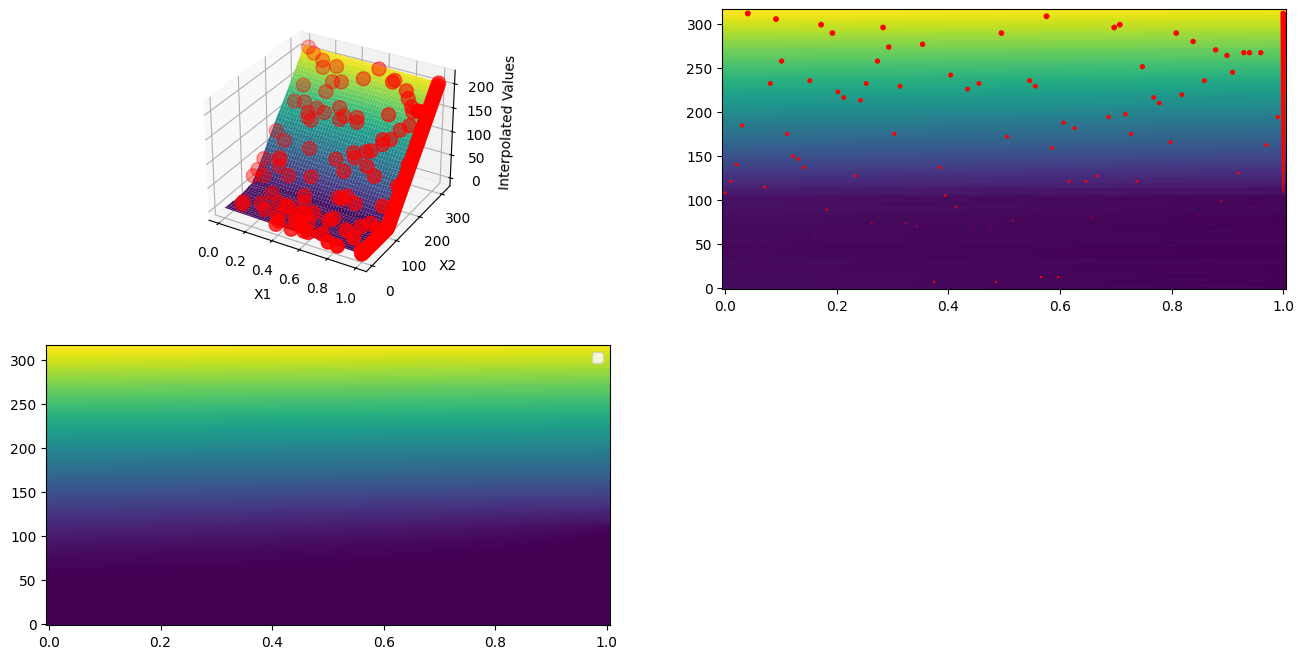

In [90]:
# Plot the interpolated surface
fig = plt.figure(figsize=[16,8])
ax = fig.add_subplot(221, projection='3d')
ax.plot_surface(T, S, interpolated_values.reshape(S.shape), cmap='viridis')

# Plot the original data points
ax.scatter(new_X[:, 1], new_X[:, 0], new_Y, c='red', s=100, label='Original Data')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Interpolated Values')

ax2 = fig.add_subplot(222)
ax2.pcolormesh(t,x,  interpolated_values.reshape(S.shape).T)
ax2.scatter(new_X[:, 1], new_X[:, 0] , s=new_Y/20, c='red', label='Original Data')
ax2 = plt.gca()

ax3 = fig.add_subplot(223)
ax3.pcolormesh(t, x, u)
ax3= plt.gca()

rse, rmse = calc_error_2d(interpolated_values.reshape(S.shape).T,u,show=True)

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Error for numerical derivation
RSE: 0.05746264088638481
RMSE: 1.0211583101319757
Error for anayltical derivation
RSE: 0.2716289472090996
RMSE: 2.655923200176624


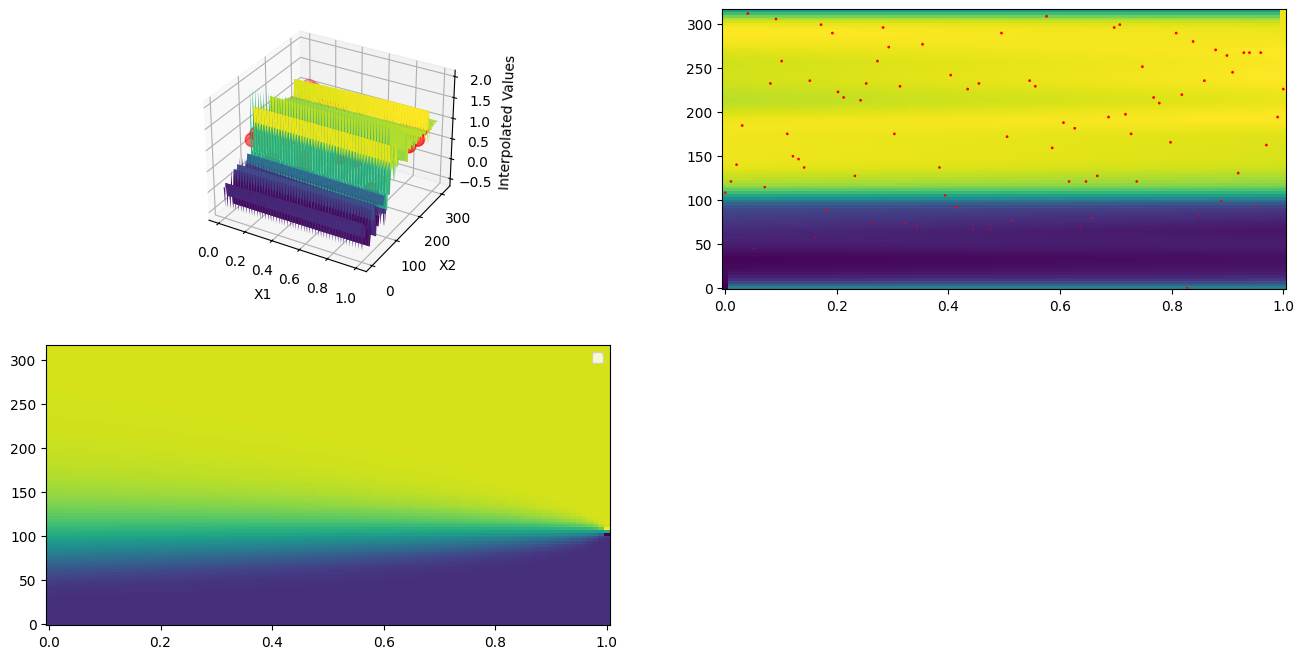

In [92]:
# Plot the interpolated surface
fig = plt.figure(figsize=[16,8])
ax = fig.add_subplot(221, projection='3d')
ax.plot_surface(T, S, interpolated_values_x.reshape(S.shape), cmap='viridis')

# Plot the original data points
ax.scatter(X[:, 1], X[:, 0], Y_x, c='red', s=100, label='Original Data')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Interpolated Values')


ax2 = fig.add_subplot(222)
ax2.pcolormesh(t,x,  smoothed_Zy.reshape(S.shape).T)
ax2.scatter(X[:, 1],X[:, 0] , s=Y_x/1, c='red', label='Original Data')
ax2 = plt.gca()

ax3 = fig.add_subplot(223)
ax3.pcolormesh(t, x, u_x)
ax3= plt.gca()

smoothed_Zy = gaussian_filter(interpolated_values_x, sigma=2)  # sigma controls the degree of smoothing

numerical_derivative_interpolated = ps.FiniteDifference(axis=0,order = 2)._differentiate(interpolated_values,t = np.ravel(S))
print('Error for numerical derivation')
rse, rmse = calc_error_2d(smoothed_Zy.reshape(S.shape).T,u_x,show=True)
print('Error for anayltical derivation')
rse, rmse = calc_error_2d(interpolated_values_x.reshape(S.shape).T,u_x,show=True)
plt.legend()
plt.show()




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Error for numerical derivation
RSE: 1.0017131333385623
RMSE: 1.532551266275043
Error for anayltical derivation
RSE: 1.0003678681873778
RMSE: 9.129090683450345


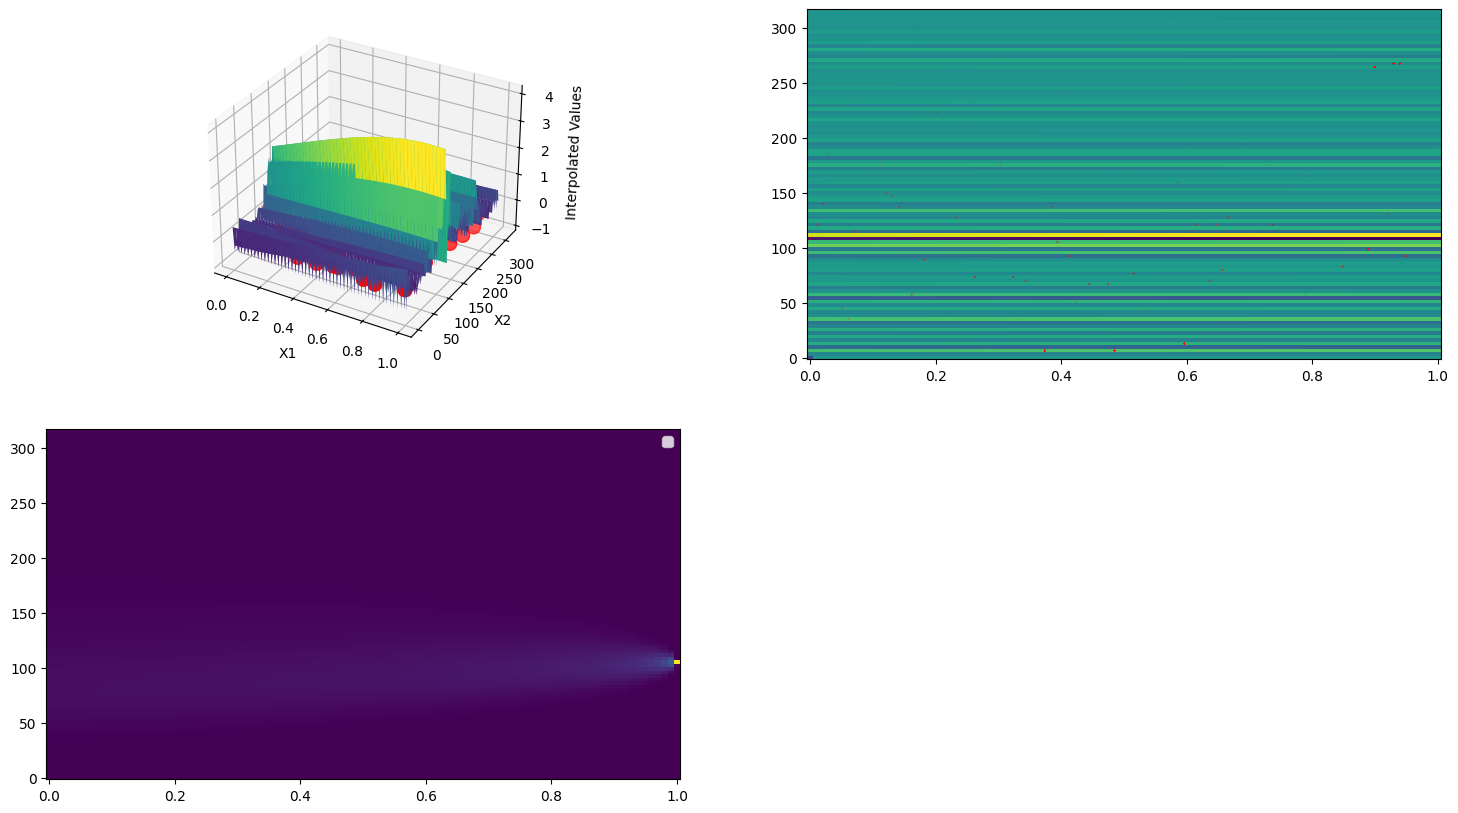

In [85]:
# Plot the interpolated surface
fig = plt.figure(figsize=[18,10])
ax = fig.add_subplot(221, projection='3d')
ax.plot_surface(T, S, interpolated_values_xx.reshape(S.shape), cmap='viridis')

# Plot the original data points
ax.scatter(X[:, 1], X[:, 0], Y_xx, c='red', s=100, label='Original Data')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Interpolated Values')

ax2 = fig.add_subplot(222)
ax2.pcolormesh(T,S,  interpolated_values_xx.reshape(S.shape))
ax2.scatter(X[:, 1],X[:, 0] , s=Y_xx*10, c='red', label='Original Data')
ax2 = plt.gca()

ax3 = fig.add_subplot(223)
ax3.pcolormesh(t, x, u_xx)
ax3= plt.gca()

numerical_2nd_derivative_interpolated = ps.FiniteDifference(axis=0,order = 2,d=2)._differentiate(interpolated_values,t = np.ravel(S))
print('Error for numerical derivation')
rse, rmse = calc_error_2d(numerical_2nd_derivative_interpolated.reshape(S.shape),u_xx,show=True)
print('Error for anayltical derivation')
rse, rmse = calc_error_2d(interpolated_values_xx.reshape(S.shape),u_xx,show=True)


plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


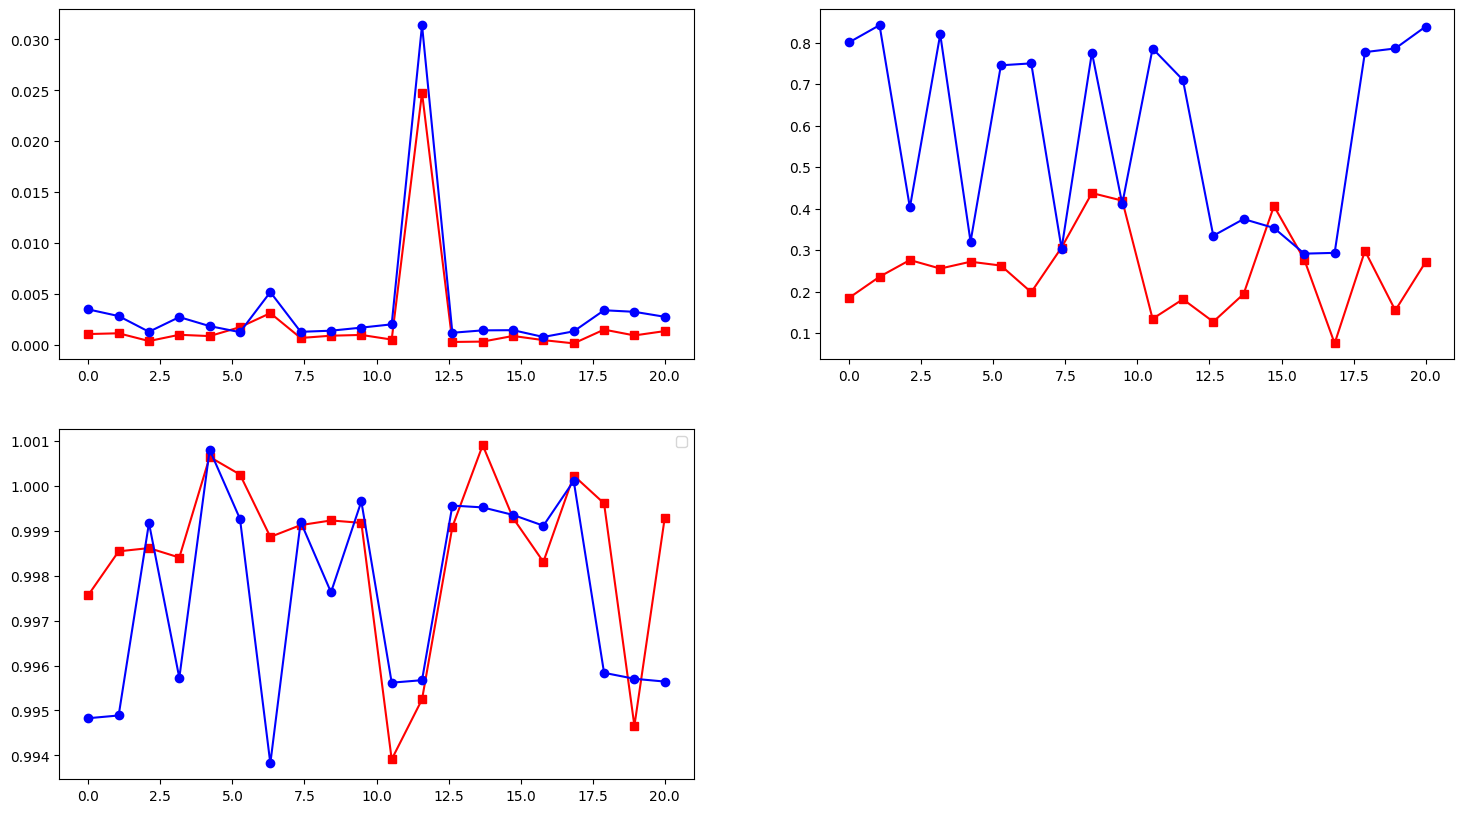

In [14]:
rse = []
rse_x= []
rse_xx = []


for i in range(20):
    subsampled_u,subsampled_x,random_rows = subsample_f(u,t,x,timesteps)
    # Sample data points and values
    X = np.array([list(a) for a in zip(subsampled_x,t)])

    Y = np.ravel(u[random_rows,np.linspace(0,timesteps-1,timesteps,dtype=int)])
    Y_x = np.ravel(u_x[random_rows,np.linspace(0,timesteps-1,timesteps,dtype=int)])
    Y_xx = np.ravel(u_xx[random_rows,np.linspace(0,timesteps-1,timesteps,dtype=int)])

    for rbf_func in (cubic_rbf(),multiquadratic_rbf()):
        # Interpolate the surface
        new_X,new_Y = build_final_condition(X,Y,K_)

        x1_grid,x2_grid, interpolated_values,interpolated_values_x,interpolated_values_xx,_ = RBFN_2d(new_X,new_Y,K_,rbf_func)

        numerical_2nd_derivative_interpolated = ps.SmoothedFiniteDifference(axis=0,order = 7,d=2)._differentiate(interpolated_values,t = np.ravel(S))
        numerical_derivative_interpolated = ps.SmoothedFiniteDifference(axis=0,order = 7)._differentiate(interpolated_values,t = np.ravel(S))

        rse.append(calc_error_2d(interpolated_values.reshape(S.shape).T,u)[0])
        rse_x.append(calc_error_2d(interpolated_values_x.reshape(S.shape).T,u_x)[0])
        rse_xx.append(calc_error_2d(interpolated_values_xx.reshape(S.shape).T,u_xx)[0])

time = np.linspace(0,20,20)



fig = plt.figure(figsize=[18,10])
ax = fig.add_subplot(221)
ax.plot(time, rse[0::2], c='r',marker='s')
ax.plot(time,rse[1::2],c='b',marker='o')


ax2 = fig.add_subplot(222)
ax2.plot(time,rse_x[0::2],c='r',marker='s')
ax2.plot(time,rse_x[1::2],c='b',marker='o')

ax3 = fig.add_subplot(223)
ax3.plot(time,rse_xx[0::2],c='r',marker='s')
ax3.plot(time,rse_xx[1::2],c='b',marker='o')

plt.legend()
plt.show()

In [15]:
def build_cross_library(Theta,Theta_names):
    m = Theta.shape[1]
    for i in range(m):
        for j in range(i+1,m):
            Theta_names = np.hstack((Theta_names,Theta_names[i] + '*' + Theta_names[j]))
            Theta = np.hstack((Theta,(Theta[:,i]*Theta[:,j]).reshape(-1,1)))
    return Theta, Theta_names

In [93]:
# Interpolate the surface
x1_grid,x2_grid, interpolated_values,interpolated_values_x,numerical_2nd_derivative_interpolated,_ = RBFN_2d(new_X, new_Y,K_,cubic_rbf())

_,_, _,interpolated_values_t,_,_ = RBFN_2d(new_X[:,[1,0]], new_Y,K_,cubic_rbf())

smoothed_Zt = gaussian_filter(interpolated_values_t,sigma=2)

In [94]:
Theta = np.array([np.ravel(x1_grid),np.ravel(x1_grid)**2,interpolated_values,smoothed_Zy,numerical_2nd_derivative_interpolated]).T

In [95]:
Crossed_Theta,Theta_names = build_cross_library(Theta,['x','x^2','u','u_x','u_xx'])

In [101]:
optimizer = ps.STLSQ(threshold=1e-2, alpha=1e4).fit(Crossed_Theta,interpolated_values_t)

print_model(optimizer.coef_[0],Theta_names,precision=5)

u_t = + -0.07594 x + 0.07565 u + 0.14332 u_x + 0.01122 u*u_x


In [36]:
lambdas = np.linspace(1e-5,1e-1,50)
thresholds = np.linspace(1e-2,1e5,50)
best_hyperparameters(Theta,interpolated_values_t,lambdas,thresholds)

(8000, 5) (8000,)


(1e-05, 0.01)

In [50]:
def cubic_rbf_func(r):
    return r**3

def rbf_interpolation_and_derivative(x, y, f):
    N = len(x)
    Phi = np.zeros((N, N))
    
    # Construct the RBF matrix
    for i in range(N):
        for j in range(N):
            r = np.sqrt((x[i] - x[j])**2 + (y[i] - y[j])**2)
            Phi[i, j] = cubic_rbf_func(r)
    
    # Solve for lambda coefficients
    lambdas = np.linalg.solve(Phi, f)
    
    # Compute the derivatives
    dx_values = np.zeros(N)
    dy_values = np.zeros(N)
    for i in range(N):
        for j in range(N):
            r = np.sqrt((x[i] - x[j])**2 + (y[i] - y[j])**2)
            if r != 0:
                dx_values[i] += lambdas[j] * 3 * (x[i] - x[j]) / r**2
                dy_values[i] += lambdas[j] * 3 * (y[i] - y[j]) / r**2
    
    return dx_values, dy_values

In [51]:

def rbf_interpolation_and_derivatives_on_grid(x, y, f,x_grid,y_grid):
    N = len(x)
    Phi = np.zeros((N, N))
    
    # Construct the RBF matrix
    for i in range(N):
        for j in range(N):
            r = np.sqrt((x[i] - x[j])**2 + (y[i] - y[j])**2)
            Phi[i, j] = cubic_rbf_func(r)
    
    # Solve for lambda coefficients
    lambdas = np.linalg.solve(Phi, f)
    
    # Create a grid spanning the range of x and y values
    # x_grid = np.linspace(min(x), max(x), 100)
    # y_grid = np.linspace(min(y), max(y), 100)
    X, Y = np.meshgrid(x_grid, y_grid)
    
    # Evaluate the RBF interpolant, its first and second derivatives over the grid
    Z = np.zeros_like(X)
    Zx = np.zeros_like(X)
    Zy = np.zeros_like(X)
    Zxx = np.zeros_like(X)
    Zyy = np.zeros_like(X)
    Zxy = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            for k in range(N):
                dx = X[i, j] - x[k]
                dy = Y[i, j] - y[k]
                r = np.sqrt(dx**2 + dy**2)
                if r != 0:  # Avoid division by zero
                    Z[i, j] += lambdas[k] * cubic_rbf_func(r)
                    Zx[i, j] += lambdas[k] * 3 * dx * r
                    Zy[i, j] += lambdas[k] * 3 * dy * r
                    Zxx[i, j] += lambdas[k] * 3 * (1 - dx**2 / r**2)
                    Zyy[i, j] += lambdas[k] * 3 * (1 - dy**2 / r**2)
                    Zxy[i, j] += lambdas[k] * 3 * dx * dy / r**2
    
    return X, Y, Z, Zx, Zy, Zxx, Zyy, Zxy

In [52]:
Xi, Yi, Zi,Zx,Zy,Zxx, Zyy, Zxy = rbf_interpolation_and_derivatives_on_grid(t, subsampled_x, Y,t,x)


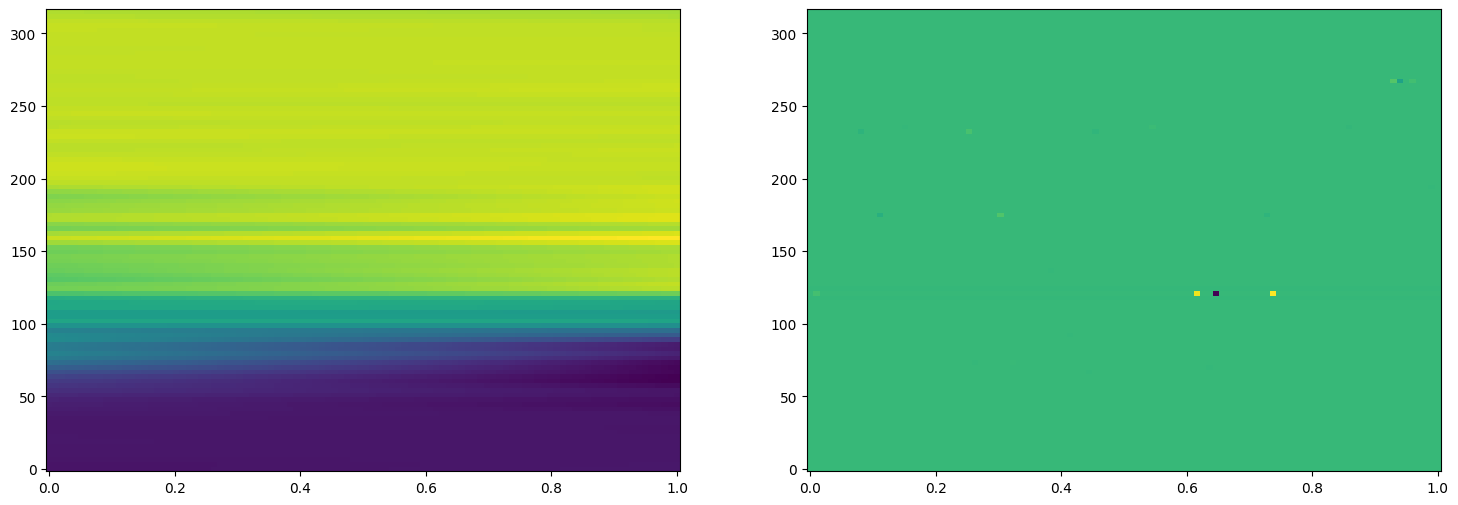

In [59]:
from scipy.ndimage import gaussian_filter

# Assuming Z is the interpolated grid data from the previous function
smoothed_Zy = gaussian_filter(Zy, sigma=1)  # sigma controls the degree of smoothing
plt.figure(figsize=[18,6])
plt.subplot(1,2,1)
plt.pcolormesh(T,S,smoothed_Zy.T)

plt.subplot(1,2,2)
plt.pcolormesh(T,S,Zyy.T)


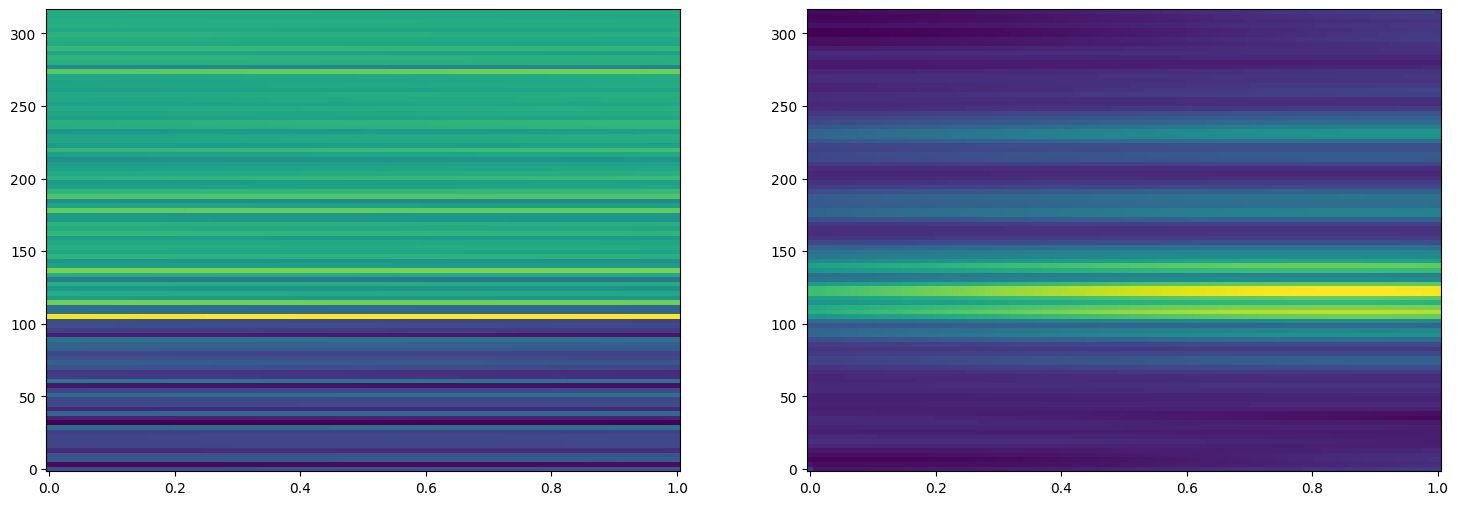

In [61]:

plt.figure(figsize=[18,6])
plt.subplot(1,2,1)
plt.pcolormesh(T,S,interpolated_values_x.reshape((100,100)))

plt.subplot(1,2,2)
smoothed_Zy = gaussian_filter(interpolated_values_xx, sigma=1)  # sigma controls the degree of smoothing

plt.pcolormesh(T,S,interpolated_values_xx.reshape((100,100)))


In [55]:
Theta = np.array([np.ravel(x1_grid),np.ravel(x1_grid)**2,np.ravel(Zi.T),np.ravel(Zy.T),np.ravel(Zyy.T)]).T

In [56]:
Crossed_Theta,Theta_names = build_cross_library(Theta,['x','x^2','u','u_x','u_xx'])

In [57]:
optimizer = ps.STLSQ(threshold=1e-2, alpha=1e4).fit(Crossed_Theta,np.ravel(Zx))

print_model(optimizer.coef_[0],Theta_names,precision=5)

u_t = + -0.11071 x + 0.214 u + 0.05096 x*u_x + -0.15652 u*u_x
